In [1]:
import sys

import math
from scipy import stats
import csv
import numpy as np
import torch
import gpytorch
from sklearn import preprocessing
from sklearn.utils import shuffle
import scipy
from scipy.special import logit, expit
from matplotlib import pyplot as plt

In [2]:
sys.path.insert(0, '/Users/Lorena/ML_IPAM/IPAM2021_ML/utils')
from utils import writeResult

## Read and shuffle data

In [3]:
def extractData(filename, verbose=False):
    """ Reads data from csv file and returns it in array form.
    Parameters
    ----------
    filename : str
        File path of data file to read
    Returns
    -------
    data : arr
    """
    lst=[]
    header = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        header.append(next(csv_reader))
        for row in csv_reader:
            lst.append(row)
    data=np.array(lst, dtype=float)
    if verbose:
        print(filename, 'loaded')
    return header, data

In [4]:
_, train_data = extractData('/Users/Lorena/ML_IPAM/ipam_NS_set/train_NS.csv')
_, test_data = extractData('/Users/Lorena/ML_IPAM/ipam_NS_set/test_NS.csv')

In [5]:
ytrain = train_data[:20000,1:3]
xtrain = train_data[:20000,9:11]
ytest = test_data[:4000,1:3]
xtest = test_data[:4000,9:11]

## Read predictions

In [6]:
# If reading csv data, run this
def extractData(filename, verbose=False):
    """ Reads data from csv file and returns it in array form.
    Parameters
    ----------
    filename : str
        File path of data file to read
    Returns
    -------
    data : arr
    """
    lst=[]
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            lst.append(row)
    data=np.array(lst, dtype=float)
    if verbose:
        print(filename, 'loaded')
    return data


predicted_data = extractData('../data_files/20k_real.csv')
#predicted_data = extractData('../data_files/just_RBF.csv')

# Plotting

In [7]:
color_cycle = [
        (53/255.,  74/255.,  93/255.),   # black
        (59/255.,  153/255., 217/255.),  # blue
        (229/255., 126/255., 49/255.),   # orange
        (53/255.,  206/255., 116/255.),  # green
        (230/255., 78/255.,  67/255.),   # red
        (154/255., 91/255.,  179/255.),  # purple
        (240/255., 195/255., 48/255.),   # gold
        '#e377c2',                       # pink
        '#8c564b',                       # brown
        '#7f7f7f',                       # gray
        '#17becf',                       # teal
        '#bcbd22',                       # lime
    ]

Define different types of errors for plotting

In [8]:
inj_rec_err = (ytest - xtest) /ytest
inj_pred_err = (ytest - predicted_data) /ytest

## Shapiro test

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

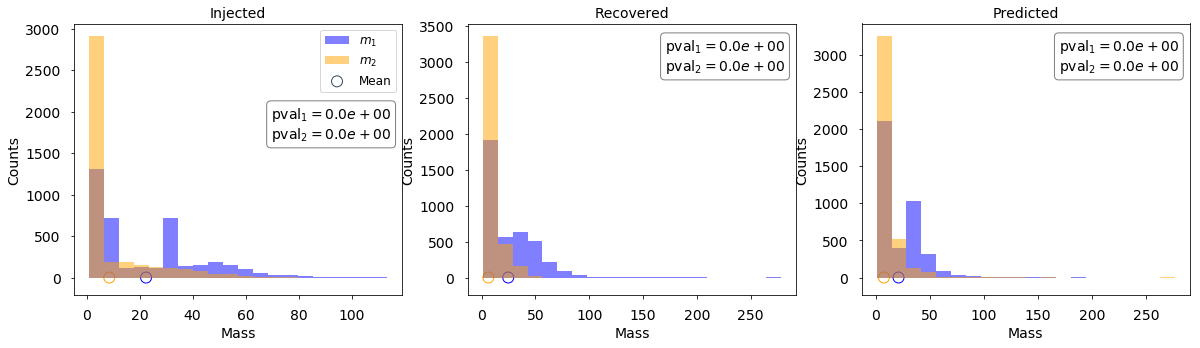

In [9]:
fig, axis = plt.subplots(1,3, figsize=(20,5))

combined_epsilons = [ytest[:,0], ytest[:,1]]

hist, bins, _ = axis[0].hist(combined_epsilons, 20)
axis[0].clear()
axis[0].set_title(r'Injected', fontsize=14)
axis[0].set_xlabel(r'Mass', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$','$m_2$']

color = ['blue','orange']
for i in range(len(combined_epsilons)):
    axis[0].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[0].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)

axis[0].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')

axis[0].legend(ncol = 1, loc="upper right", fontsize=12)
###############
combined_epsilons = [xtest[:,0], xtest[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons, 20)
axis[1].clear()
axis[1].set_title(r'Recovered', fontsize=14)
axis[1].set_xlabel(r'Mass', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$','$m_2$']

color = ['blue','orange']
for i in range(len(combined_epsilons)):
    axis[1].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[1].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)


axis[1].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')

#axis[1].legend(ncol = 1, loc="upper right", fontsize=12)
###############
combined_epsilons = [predicted_data[:,0], predicted_data[:,1]]

hist, bins, _ = axis[2].hist(combined_epsilons, 20)
axis[2].clear()
axis[2].set_title(r'Predicted', fontsize=14)
axis[2].set_xlabel(r'Mass', fontsize=14)
axis[2].set_ylabel(r'Counts', fontsize=14)
axis[2].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$','$m_2$']

color = ['blue','orange']
for i in range(len(combined_epsilons)):
    axis[2].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[2].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)


axis[2].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')
#axis[2].legend(ncol = 1, loc="upper right", fontsize=12)

# This is just showing how 
shap_inj1 = stats.shapiro(ytest[:4000,0]) #injected
shap_rec1 = stats.shapiro(xtest[:4000,0]) #recovered
shap_pred1 = stats.shapiro(predicted_data[:4000,0]) #predicted

shap_inj2 = stats.shapiro(ytest[:4000,1]) #injected
shap_rec2 = stats.shapiro(xtest[:4000,1]) #recovered
shap_pred2 = stats.shapiro(predicted_data[:4000,1]) #predicted

textstr1 = '\n'.join((
    r'$\mathrm{pval}_1=%.1e$' % (shap_inj1.pvalue, ),
    r'$\mathrm{pval}_2=%.1e$' % (shap_inj2.pvalue, )))
textstr2 = '\n'.join((
    r'$\mathrm{pval}_1=%.1e$' % (shap_rec1.pvalue, ),
    r'$\mathrm{pval}_2=%.1e$' % (shap_rec2.pvalue, )))
textstr3 = '\n'.join((
    r'$\mathrm{pval}_1=%.1e$' % (shap_pred1.pvalue, ),
    r'$\mathrm{pval}_2=%.1e$' % (shap_pred2.pvalue, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

axis[0].text(0.6, 0.7, textstr1, transform=axis[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axis[1].text(0.6, 0.95, textstr2, transform=axis[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axis[2].text(0.6, 0.95, textstr3, transform=axis[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

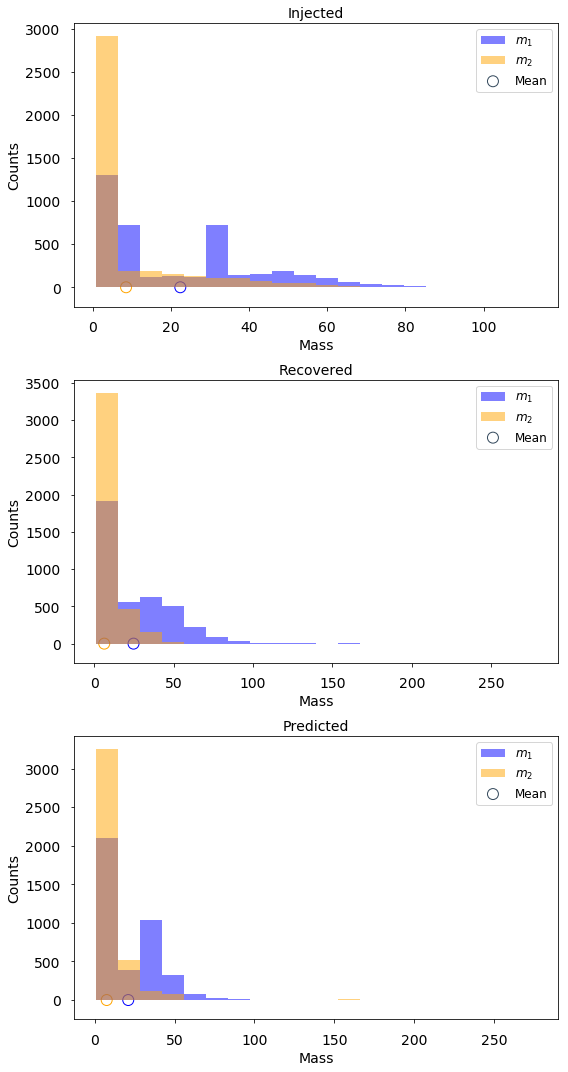

In [10]:
fig, axis = plt.subplots(3,1, figsize=(8,15))

combined_epsilons = [ytest[:,0], ytest[:,1]]

hist, bins, _ = axis[0].hist(combined_epsilons, 20)
axis[0].clear()
axis[0].set_title(r'Injected', fontsize=14)
axis[0].set_xlabel(r'Mass', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$','$m_2$']

color = ['blue','orange']
for i in range(len(combined_epsilons)):
    axis[0].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[0].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)

axis[0].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')

axis[0].legend(ncol = 1, loc="upper right", fontsize=12)
###############
combined_epsilons = [xtest[:,0], xtest[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons, 20)
axis[1].clear()
axis[1].set_title(r'Recovered', fontsize=14)
axis[1].set_xlabel(r'Mass', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$','$m_2$']

color = ['blue','orange']
for i in range(len(combined_epsilons)):
    axis[1].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[1].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)


axis[1].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')

axis[1].legend(ncol = 1, loc="upper right", fontsize=12)
###############
combined_epsilons = [predicted_data[:,0], predicted_data[:,1]]

hist, bins, _ = axis[2].hist(combined_epsilons, 20)
axis[2].clear()
axis[2].set_title(r'Predicted', fontsize=14)
axis[2].set_xlabel(r'Mass', fontsize=14)
axis[2].set_ylabel(r'Counts', fontsize=14)
axis[2].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$','$m_2$']

color = ['blue','orange']
for i in range(len(combined_epsilons)):
    axis[2].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[2].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)


axis[2].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')

axis[2].legend(ncol = 1, loc="upper right", fontsize=12)

#axis[0].set_xlim(0.9,2.4)
#axis[1].set_xlim(0.9,2.4)
#axis[2].set_xlim(0.9,2.4)
plt.tight_layout()
plt.show()

In [11]:
n = np.linspace(3,5000,4998)

shap_inj1 = []; shap_rec1 = []; shap_pred1 = []
shap_inj2 = []; shap_rec2 = []; shap_pred2 = []


for k in n:
    shap_inj1.append(stats.shapiro(ytest[:int(k),0]).pvalue)
    shap_rec1.append(stats.shapiro(xtest[:int(k),0]).pvalue) #recovered
    shap_pred1.append(stats.shapiro(predicted_data[:int(k),0]).pvalue) #predicted

    shap_inj2.append(stats.shapiro(ytest[:int(k),1]).pvalue) #injected
    shap_rec2.append(stats.shapiro(xtest[:int(k),1]).pvalue) #recovered
    shap_pred2.append(stats.shapiro(predicted_data[:int(k),1]).pvalue) #predicted

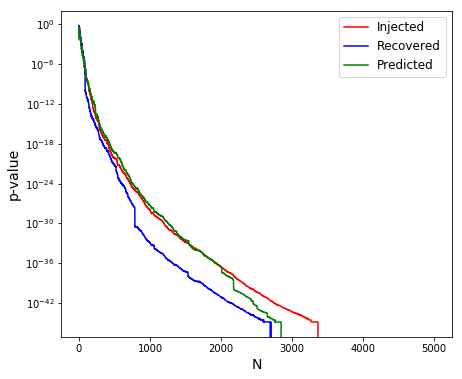

In [12]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.plot(n, shap_inj1, 'r-', label='Injected')

plt.plot(n, shap_rec1, 'b-', label='Recovered')

plt.plot(n, shap_pred1, 'g-', label='Predicted')       

plt.xlabel('N', fontsize=14)
plt.ylabel('p-value', fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')

outfile = '../figs/SW_test.pdf'
plt.savefig(outfile, bbox_inches="tight")

plt.show()

ShapiroResult(statistic=0.6315011382102966, pvalue=0.0)
ShapiroResult(statistic=0.3434324860572815, pvalue=0.0)
ShapiroResult(statistic=0.6769450902938843, pvalue=0.0)
ShapiroResult(statistic=0.0422978401184082, pvalue=0.0)


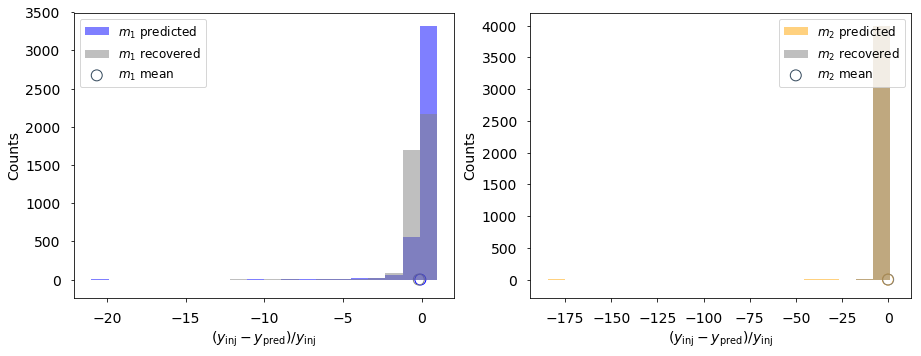

In [13]:
fig, axis = plt.subplots(1,2, figsize=(15,5.25))

combined_epsilons = [inj_pred_err[:,0], inj_rec_err[:,0]]
hist, bins, _ = axis[0].hist(combined_epsilons, 20)
axis[0].clear()
axis[0].set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ predicted','$m_1$ recovered']

color = ['blue','gray']
for i in range(len(combined_epsilons)):
    axis[0].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[0].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)

axis[0].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='$m_1$ mean')
axis[0].legend(ncol = 1, loc="upper left", fontsize=12)

###################

combined_epsilons = [inj_pred_err[:,1], inj_rec_err[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons, 20)
axis[1].clear()
axis[1].set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_2$ predicted','$m_2$ recovered']

color = ['orange','gray']
for i in range(len(combined_epsilons)):
    axis[1].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[1].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    point.set_clip_on(False)
    
axis[1].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='$m_2$ mean')
axis[1].legend(ncol = 1, loc="upper right", fontsize=12)

inj_rec_err = (ytest - xtest) /ytest
inj_pred_err = (ytest - predicted_data) /ytest
print(stats.shapiro(inj_rec_err[:4000,0]))
print(stats.shapiro(inj_pred_err[:4000,0]))

print(stats.shapiro(inj_rec_err[:4000,1]))
print(stats.shapiro(inj_pred_err[:4000,1]))

plt.show()

## Epps-Singleton test

Test the null hypothesis that two samples have the same underlying probability distribution.

In [14]:
print(scipy.stats.epps_singleton_2samp(ytest[:100,0], xtest[:100,0]))
print(scipy.stats.epps_singleton_2samp(ytest[:100,0], predicted_data[:100,0]))

Epps_Singleton_2sampResult(statistic=1.6301612312066123, pvalue=0.803361296731123)
Epps_Singleton_2sampResult(statistic=2.1694200233759844, pvalue=0.7046315413087079)


## Kolmogorov-Smirnov test

This test compares the underlying continuous distributions F(x) and G(x) of two independent samples.

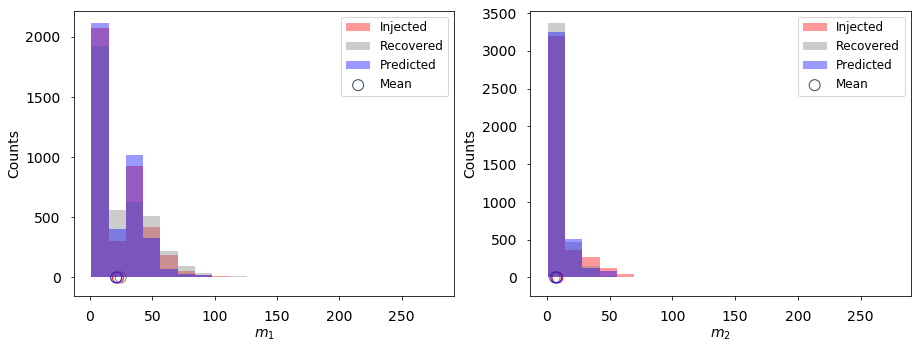

In [15]:
fig, axis = plt.subplots(1,2, figsize=(15,5.25))

combined_epsilons = [ytest[:,0], xtest[:,0], predicted_data[:,0]]

hist, bins, _ = axis[0].hist(combined_epsilons, 20)
axis[0].clear()
axis[0].set_xlabel(r'$m_1$', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-', '-']
labels = ['Injected','Recovered','Predicted']

color = ['red','gray','blue']
for i in range(len(combined_epsilons)):
    axis[0].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.4)
    point = axis[0].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    #points = axis[0].scatter(x=np.median(combined_epsilons[i]), y=0, s=60, facecolors='none', edgecolors=color[i])
    #print('The median is: ',np.mean(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)
    #points.set_clip_on(False)


axis[0].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')
axis[0].legend(ncol = 1, loc="upper right", fontsize=12)
#####################

combined_epsilons = [ytest[:,1], xtest[:,1], predicted_data[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons, 20)
axis[1].clear()
axis[1].set_xlabel(r'$m_2$', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-', '-']
labels = ['Injected','Recovered','Predicted']

color = ['red','gray','blue']
for i in range(len(combined_epsilons)):
    axis[1].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.4)
    point = axis[1].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    #points = axis[0].scatter(x=np.median(combined_epsilons[i]), y=0, s=60, facecolors='none', edgecolors=color[i])
    #print('The median is: ',np.mean(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)
    #points.set_clip_on(False)


axis[1].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='Mean')
axis[1].legend(ncol = 1, loc="upper right", fontsize=12)


plt.show()

In [16]:
scipy.stats.ks_2samp(ytest[:,1], xtest[:,1], alternative='two-sided', mode='auto')
# we are testing if the dist of injected values are equal to the recovered here, and since the 
# p-value is 0, it is telling us "absolutely not! they are quite different!"

KstestResult(statistic=0.2475, pvalue=6.1349568304925e-108)

In [17]:
scipy.stats.ks_2samp(ytest[:,1], xtest[:,1], alternative='less', mode='auto')
# we are testing if the injected values are typically less than recovered here, and since the 
# p-value is 1.0, it is telling us "definitely yes!"

KstestResult(statistic=0.2475, pvalue=3.0674784152462364e-108)

In [18]:
scipy.stats.ks_2samp(ytest[:,1], xtest[:,1], alternative='greater', mode='auto')
# we are testing if injected values are greater than recovered here, and since the 
# p-value is 0, it is telling us "absolutely not!"

KstestResult(statistic=0.144, pvalue=7.192693469982654e-37)

In [19]:
scipy.stats.ks_2samp(ytest[:,1], predicted_data[:,1], alternative='two-sided', mode='auto')
# we are testing if the injected values are equal to the predicted here, and since the 
# p-value is small, it is telling us "they are not completely different, but not the 
# same. there is some overlap!"

KstestResult(statistic=0.06375, pvalue=1.7263335509632056e-07)

In [20]:
scipy.stats.ks_2samp(ytest[:,1], predicted_data[:,1], alternative='less', mode='auto')
# we are testing if the injected values are less than predicted here, and since the 
# p-value is small, it is telling us "this is true sometimes, there is some overlap!"

KstestResult(statistic=0.06375, pvalue=8.631667754816007e-08)

In [21]:
scipy.stats.ks_2samp(ytest[:,1], predicted_data[:,1], alternative='greater', mode='auto')
# we are testing if injected values are greater than predicted here, and since the 
# p-value is very small, it is telling us "not always true!"

KstestResult(statistic=0.04925, pvalue=6.0980166081296104e-05)

## T-test

This is a test for the null hypothesis that two independent samples have identical average (expected) values.

In [22]:
scipy.stats.ttest_ind_from_stats(np.mean(ytest[:,0]), np.std(ytest[:,0]), len(ytest[:,0]), \
                                 np.mean(xtest[:,0]), np.std(xtest[:,0]), len(xtest[:,0]), \
                                 equal_var=False, alternative='greater')

Ttest_indResult(statistic=-4.601415399315789, pvalue=0.9999978687447131)

In [23]:
scipy.stats.ttest_ind_from_stats(np.mean(ytest[:,0]), np.std(ytest[:,0]), len(ytest[:,0]), \
                                 np.mean(predicted_data[:,0]), np.std(predicted_data[:,0]), len(predicted_data[:,0]), \
                                 equal_var=False, alternative='greater')

Ttest_indResult(statistic=3.128590681411302, pvalue=0.0008813984013910747)

## Binning